In [1]:
import numpy as np
import sys
sys.path.append('../../../')

# Define experiment parameters

In [2]:
from koopman_core.systems import PlanarQuadrotorForceInput

n, m = 6, 2 
mass = 2.
inertia = 1.
prop_arm = 0.2
gravity = 9.81
quadrotor = PlanarQuadrotorForceInput(mass, inertia, prop_arm, g=gravity)

q,r = 1e5, 1
dt = 1e-2
hover_thrust = mass*gravity/m
hover_offset = np.array([hover_thrust, hover_thrust])
xmax = np.array([2, 2, np.pi/3, 2.,2.,2.])                          # State constraints, trajectory generation
xmin = -xmax
umax = np.array([20, 20])                                           # Actuation constraint, trajectory generation
umin = np.array([0., 0.])

x0_cl = np.array([-1., 0., 0., 0., 0., 0.])                         # Initial value, closed loop trajectory
set_pt_cl = np.array([1., 1., 0., 0., 0., 0.])                      # Desired final value, closed loop trajectory

# Define nonlinear MPC for trajectory generation

#### Define model

In [3]:
from casadi import *
import do_mpc

model = do_mpc.model.Model('continuous')
xpos = model.set_variable('_x', 'xpos')
zpos = model.set_variable('_x', 'zpos')
theta = model.set_variable('_x', 'theta')
dxpos = model.set_variable('_x', 'dxpos')
dzpos = model.set_variable('_x', 'dzpos')
dtheta = model.set_variable('_x', 'dtheta')
u = model.set_variable('_u', 'force', (2,1))

ddxpos = model.set_variable('_z', 'ddxpos')
ddzpos = model.set_variable('_z', 'ddzpos')
ddtheta = model.set_variable('_z', 'ddtheta')

model.set_rhs('xpos', dxpos)
model.set_rhs('zpos', dzpos)
model.set_rhs('theta', dtheta)
model.set_rhs('dxpos', ddxpos)
model.set_rhs('dzpos', ddzpos)
model.set_rhs('dtheta', ddtheta)

mass = 2.
inertia = 1.
prop_arm = 0.2
gravity = 9.81
eul_lagrange = vertcat(
    ddxpos-(-(1 / mass) * sin(theta)*u[0] - (1 / mass) * sin(theta) * u[1]),
    ddzpos-(-gravity + (1 / mass) * cos(theta) * u[0] + (1 / mass) * cos(theta) * u[1]),
    ddtheta - (-(prop_arm / inertia) * u[0] + (prop_arm / inertia) * u[1])
)
model.set_alg('euler_lagrange', eul_lagrange)
quad_cost = (q*(xpos-set_pt_cl[0]) ** 2 
                 +q*(zpos-set_pt_cl[1]) ** 2 
                 +q*(theta-set_pt_cl[2]) ** 2
                 +(q)*(dxpos-set_pt_cl[3]) ** 2 
                 +(q)*(dzpos-set_pt_cl[4]) ** 2 
                 +(q)*(dtheta-set_pt_cl[5]) ** 2)
model.set_expression(expr_name='cost', expr=quad_cost)
model.setup()

#### Define controller

In [4]:
mpc = do_mpc.controller.MPC(model)
setup_mpc = {
    'n_horizon': 200,
    'n_robust': 0,
    'open_loop': 0,
    't_step': 0.01,
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 2,
    'collocation_ni': 2,
    'store_full_solution': True,
    # Use MA27 linear solver in ipopt for faster calculations:
    'nlpsol_opts': {'ipopt.linear_solver': 'mumps'}
}
mpc.set_param(**setup_mpc)
mpc.set_objective(lterm=SX.zeros(1,1), mterm=model.aux['cost'])
mpc.set_rterm(force=np.array([r, r]))

mpc.bounds['lower', '_x', 'xpos'] = xmin[0]
mpc.bounds['lower', '_x', 'zpos'] = xmin[1]
mpc.bounds['lower', '_x', 'theta'] = xmin[2]
mpc.bounds['lower', '_x', 'dxpos'] = xmin[3]
mpc.bounds['lower', '_x', 'dzpos'] = xmin[4]
mpc.bounds['lower', '_x', 'dtheta'] = xmin[5]
mpc.bounds['upper', '_x', 'xpos'] = xmax[0]
mpc.bounds['upper', '_x', 'zpos'] = xmax[1]
mpc.bounds['upper', '_x', 'theta'] = xmax[2]
mpc.bounds['upper', '_x', 'dxpos'] = xmax[3]
mpc.bounds['upper', '_x', 'dzpos'] = xmax[4]
mpc.bounds['upper', '_x', 'dtheta'] = xmax[5]

mpc.bounds['lower','_u','force'] = umin
mpc.bounds['upper', '_u', 'force'] = umax

mpc.setup()

#### Set up simulation and evaluate open loop prediction

In [5]:
x0 = x0_cl
mpc.x0 = x0
mpc.u0 = hover_offset
mpc.set_initial_guess()
mpc.make_step(x0)

xr_cl = np.vstack((mpc.data.prediction(('_x','xpos')).squeeze().T,
                            mpc.data.prediction(('_x','zpos')).squeeze().T,
                            mpc.data.prediction(('_x','theta')).squeeze().T,
                            mpc.data.prediction(('_x','dxpos')).squeeze().T,
                            mpc.data.prediction(('_x','dzpos')).squeeze().T,
                            mpc.data.prediction(('_x','dtheta')).squeeze().T))
ur_cl = mpc.data.prediction(('_u','force')).squeeze()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    39606
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4404

Total number of variables............................:    12442
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     8764
                     variables with only upper bounds:        0
Total number of equa

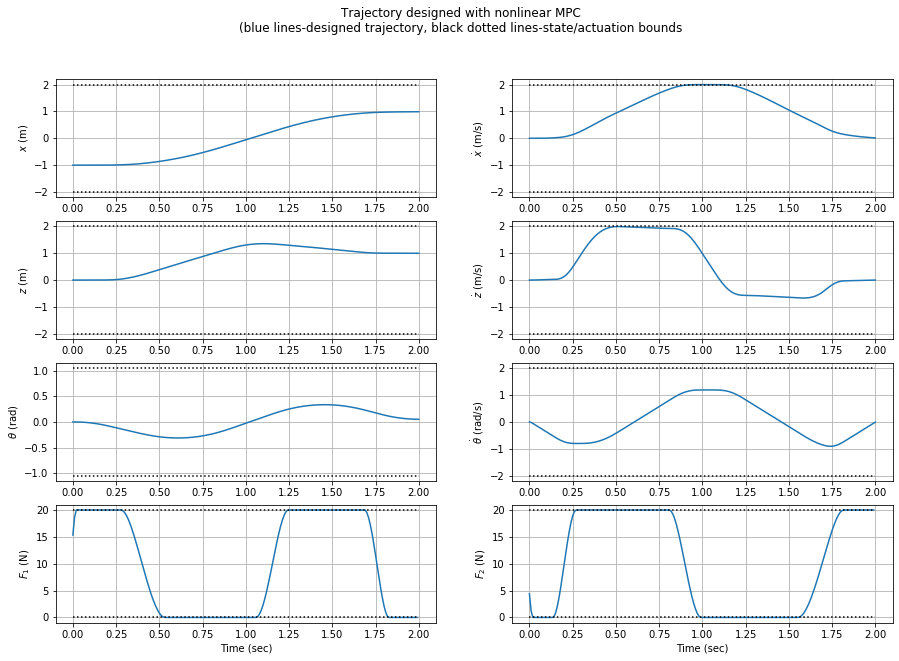

In [6]:
import matplotlib.pyplot as plt
t_eval = np.arange(0,201)*0.01
plot_inds = [0, 3, 1, 4, 2, 5, 0, 1]
labels = ['$x$ (m)', '$z$ (m)', '$\\theta$ (rad)', '$\\dot{x}$ (m/s)','$\\dot{z}$ (m/s)','$\\dot{\\theta}$ (rad/s)','$F_1$ (N)','$F_2$ (N)']

plt.figure(figsize=(15,10))
plt.suptitle('Trajectory designed with nonlinear MPC\n(blue lines-designed trajectory, black dotted lines-state/actuation bounds')
for ii in range(8):
    ind = plot_inds[ii]
    if ii < 6:
        plt.subplot(4,2,ii+1)
        plt.plot(t_eval, xr_cl[ind,:])
        plt.plot([0, 2.], [xmax[ind], xmax[ind]], ':k')
        plt.plot([0, 2.], [xmin[ind], xmin[ind]], ':k')
        plt.ylabel(labels[ind])
        plt.grid()
    else:
        plt.subplot(4,2,ii+1)
        plt.plot(t_eval[:-1],ur_cl[ind,:])
        plt.plot([0, 2.], [umax[ind], umax[ind]], ':k')
        plt.plot([0, 2.], [umin[ind], umin[ind]], ':k')
        plt.ylabel(labels[ii])
        plt.xlabel('Time (sec)')
        plt.grid()
            
plt.show()

# Design controllers based on learned models (DMD, EDMD, bilinear EDMD)

#### Load models and set controller parameters

In [7]:
import dill
from koopman_core.basis_functions import PolySineBasis
from sklearn import preprocessing

model_fname = 'examples/planar_quad_models_sim'                     # Path to save learned models
with open(model_fname, 'rb') as handle:
    p = dill.load(handle)
sys_dmd = p['sys_dmd']
model_dmd = p['model_dmd']
sys_edmd = p['sys_edmd']
model_edmd = p['model_edmd']
sys_bedmd = p['sys_bedmd']
model_bedmd = p['model_bedmd']

basis = PolySineBasis(n, poly_deg=2, cross_terms=False)
basis.construct_basis()
poly_sine_features = preprocessing.FunctionTransformer(basis.basis)
poly_sine_features.fit(np.zeros((1, n)))

N_mpc = 25
q_cl, r_cl = 1e3, 1
Q_cl = q_cl*np.identity(n)
R_cl = r_cl*np.identity(m)
umax_cl = np.array([20, 20])-hover_offset
umin_cl = np.array([0., 0.])-hover_offset

#### Design MPC using learned DMD model

In [8]:
from koopman_core.controllers import MPCController, PerturbedController

controller_dmd = MPCController(sys_dmd, N_mpc, dt, umin_cl, umax_cl, xmin, xmax, Q_cl, R_cl, Q_cl, xr_cl, const_offset=hover_offset)
controller_dmd = PerturbedController(sys_dmd,controller_dmd,0.,const_offset=hover_thrust)

#### Design MPC using learned EDMD model

In [9]:
from core.dynamics import LinearSystemDynamics

edmd_lin_sys = LinearSystemDynamics(A=sys_edmd.A, B=sys_edmd.B)
controller_edmd = MPCController(edmd_lin_sys, N_mpc, dt, umin_cl, umax_cl, xmin, xmax, Q_cl, R_cl, Q_cl, xr_cl, lifting=True, edmd_object=sys_edmd, const_offset=hover_offset)
controller_edmd = PerturbedController(sys_edmd,controller_edmd,0.,const_offset=hover_thrust)

#### Design MPC using learned bilinear EDMD model

In [10]:
from koopman_core.controllers import BilinearMPCController

controller_bedmd = BilinearMPCController(sys_bedmd, N_mpc, dt, umin_cl, umax_cl, xmin, xmax, Q_cl, R_cl, Q_cl, xr_cl, const_offset=hover_offset)
controller_bedmd = PerturbedController(sys_bedmd,controller_bedmd,0.,const_offset=hover_thrust)

# Use learned models to generate trajectories and evaluate performance

In [11]:
A_nom = np.array([[0., 0., 0., 1., 0., 0.],                         # Linearization of the true system around the origin
                  [0., 0., 0., 0., 1., 0.],
                  [0., 0., 0., 0., 0., 1.],
                  [0., 0., -gravity, 0., 0., 0.],
                  [0., 0., 0., 0., 0., 0.],
                  [0., 0., 0., 0., 0., 0.]])
B_nom = np.array([[0., 0.],                                         # Linearization of the true system around the origin
                  [0., 0.],
                  [0., 0.],
                  [0., 0.],
                  [1./mass, 1./mass],
                  [-prop_arm/inertia, prop_arm/inertia]])
nominal_sys = LinearSystemDynamics(A=A_nom, B=B_nom)

In [12]:
Q_traj = np.diag([q, q, q, q, q, q])
R_traj = r*np.eye(m)
mpc_trajgen = MPCController(nominal_sys, 200, dt, umin_cl, umax_cl, xmin, xmax, np.zeros_like(Q_traj), R_traj, Q_traj, set_pt_cl, const_offset=hover_offset)
controller_dmd_traj = MPCController(sys_dmd, 200, dt, umin_cl, umax_cl, xmin, xmax, np.zeros_like(Q_traj), R_traj, Q_traj, set_pt_cl, const_offset=hover_offset)
controller_edmd_traj = MPCController(edmd_lin_sys, 200, dt, umin_cl, umax_cl, xmin, xmax, np.zeros_like(Q_traj), R_traj, Q_traj, set_pt_cl, lifting=True, edmd_object=sys_edmd, const_offset=hover_offset)
controller_bedmd_traj = BilinearMPCController(sys_bedmd, 200, dt, umin_cl, umax_cl, xmin, xmax, np.zeros_like(Q_traj), R_traj, Q_traj, set_pt_cl, const_offset=hover_offset)

mpc_trajgen.eval(x0_cl,0.)
xr_lin = mpc_trajgen.parse_result()
ur_lin = mpc_trajgen.get_control_prediction()+hover_thrust

controller_dmd_traj.eval(x0_cl, 0.)
xr_dmd = controller_dmd_traj.parse_result()
ur_dmd = controller_dmd_traj.get_control_prediction()+hover_thrust

controller_edmd_traj.eval(x0_cl, 0.)
xr_edmd = sys_edmd.C@controller_edmd_traj.parse_result()
ur_edmd = controller_edmd_traj.get_control_prediction()+hover_thrust

controller_bedmd_traj.eval(x0_cl, 0.)
xr_bedmd = sys_bedmd.C@controller_bedmd_traj.parse_result()
ur_bedmd = controller_bedmd_traj.get_control_prediction()+hover_thrust

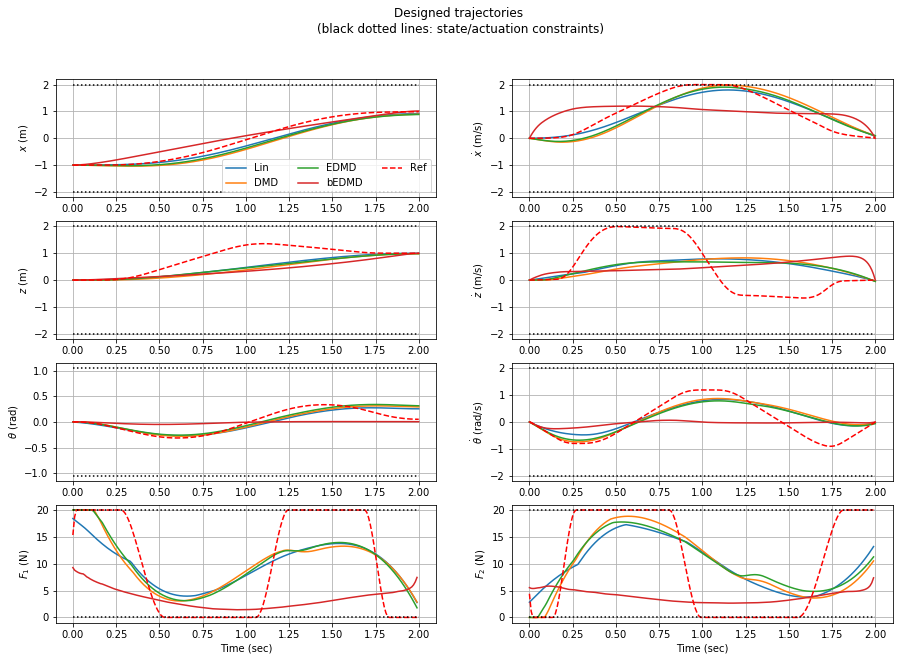

In [13]:
plot_inds = [0, 3, 1, 4, 2, 5, 0, 1]
labels = ['$x$ (m)', '$z$ (m)', '$\\theta$ (rad)', '$\\dot{x}$ (m/s)','$\\dot{z}$ (m/s)','$\\dot{\\theta}$ (rad/s)','$F_1$ (N)','$F_2$ (N)']

plt.figure(figsize=(15,10))
plt.suptitle('Designed trajectories \n(black dotted lines: state/actuation constraints)')
for ii in range(8):
    ind = plot_inds[ii]
    if ii < 6:
        plt.subplot(4,2,ii+1)
        plt.plot(t_eval, xr_lin[ind,:], label='Lin')
        plt.plot(t_eval, xr_dmd[ind,:], label='DMD')
        plt.plot(t_eval, xr_edmd[ind,:], label='EDMD')
        plt.plot(t_eval, xr_bedmd[ind,:], label='bEDMD')
        plt.plot(t_eval, xr_cl[ind,:],'--r', label='Ref')
        plt.plot([0, 2.], [xmax[ind], xmax[ind]], ':k')
        plt.plot([0, 2.], [xmin[ind], xmin[ind]], ':k')
        plt.ylabel(labels[ind])
        plt.grid()
        if ii == 0:
            plt.legend(loc='lower right', ncol=3)
    else:
        plt.subplot(4,2,ii+1)
        plt.plot(t_eval[:-1], ur_lin[ind,:], label='Lin')
        plt.plot(t_eval[:-1], ur_dmd[ind,:], label='DMD')
        plt.plot(t_eval[:-1], ur_edmd[ind,:], label='EDMD')
        plt.plot(t_eval[:-1], ur_bedmd[ind,:], label='bEDMD')
        plt.plot(t_eval[:-1],ur_cl[ind,:],'--r')
        plt.plot([0, 2.], [umax[ind], umax[ind]], ':k')
        plt.plot([0, 2.], [umin[ind], umin[ind]], ':k')
        plt.ylabel(labels[ii])
        plt.xlabel('Time (sec)')
        plt.grid()
            
plt.show()

#### Calculate cost of each controller/model

In [14]:
traj_cost_ref = xr_cl[:,-1].T@Q_traj@xr_cl[:,-1] + np.sum(np.diag(ur_cl.T@R_traj@ur_cl))
traj_cost_lin = xr_lin[:,-1].T@Q_traj@xr_lin[:,-1] + np.sum(np.diag(ur_lin.T@R_traj@ur_lin))
traj_cost_dmd = xr_dmd[:,-1].T@Q_traj@xr_dmd[:,-1] + np.sum(np.diag(ur_dmd.T@R_traj@ur_dmd))
traj_cost_edmd = xr_edmd[:,-1].T@Q_traj@xr_edmd[:,-1] + np.sum(np.diag(ur_edmd.T@R_traj@ur_edmd))
traj_cost_bedmd = xr_bedmd[:,-1].T@Q_traj@xr_bedmd[:,-1] + np.sum(np.diag(ur_bedmd.T@R_traj@ur_bedmd))

print('Closed loop quadratic cost:')
print('   Ref:   ', "{:.3f}".format(traj_cost_ref),
      '\n   Lin:   ', "{:.3f}".format(traj_cost_lin),
      '\n   DMD:   ', "{:.3f}".format(traj_cost_dmd),
      '\n   EDMD:  ', "{:.3f}".format(traj_cost_edmd),
      '\n   bEDMD: ', "{:.3f}".format(traj_cost_bedmd),
      )
print('   Relative increased cost Ref -> Linear:   ', "{:.2f}".format(100*((traj_cost_lin)/(traj_cost_ref)-1)), ' %'
      '\n   Relative increased cost Ref -> EDMD:   ', "{:.2f}".format(100*((traj_cost_edmd)/(traj_cost_ref)-1)), ' %'
      '\n   Relative increased cost Ref -> EDMD:   ', "{:.2f}".format(100*((traj_cost_edmd)/(traj_cost_ref)-1)), ' %'
      '\n   Relative increased cost Ref -> bEDMD:  ', "{:.2f}".format(100*((traj_cost_bedmd)/(traj_cost_ref)-1)), ' %'
      )

Closed loop quadratic cost:
   Ref:    272171.391 
   Lin:    237766.348 
   DMD:    236216.536 
   EDMD:   236706.359 
   bEDMD:  209779.499
   Relative increased cost Ref -> Linear:    -12.64  %
   Relative increased cost Ref -> EDMD:    -13.03  %
   Relative increased cost Ref -> EDMD:    -13.03  %
   Relative increased cost Ref -> bEDMD:   -22.92  %


# Simulate systems in closed-loop and compare performance

In [15]:
xs_cl_dmd, us_cl_dmd = quadrotor.simulate(x0_cl, controller_dmd, t_eval)
xs_cl_edmd, us_cl_edmd = quadrotor.simulate(x0_cl, controller_edmd, t_eval)
xs_cl_bedmd, us_cl_bedmd = quadrotor.simulate(x0_cl, controller_bedmd, t_eval)

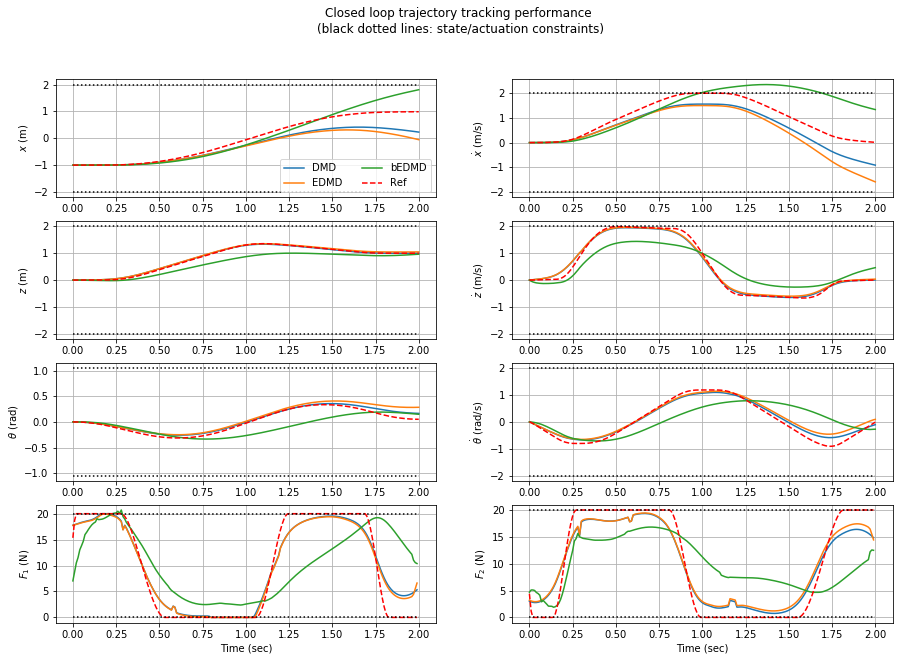

In [16]:
plot_inds = [0, 3, 1, 4, 2, 5, 0, 1]
labels = ['$x$ (m)', '$z$ (m)', '$\\theta$ (rad)', '$\\dot{x}$ (m/s)','$\\dot{z}$ (m/s)','$\\dot{\\theta}$ (rad/s)','$F_1$ (N)','$F_2$ (N)']

plt.figure(figsize=(15,10))
plt.suptitle('Closed loop trajectory tracking performance \n(black dotted lines: state/actuation constraints)')
for ii in range(8):
    ind = plot_inds[ii]
    if ii < 6:
        plt.subplot(4,2,ii+1)
        plt.plot(t_eval, xs_cl_dmd[:,ind], label='DMD')
        plt.plot(t_eval, xs_cl_edmd[:,ind], label='EDMD')
        plt.plot(t_eval, xs_cl_bedmd[:,ind], label='bEDMD')
        plt.plot(t_eval, xr_cl[ind,:],'--r', label='Ref')
        plt.plot([0, 2.], [xmax[ind], xmax[ind]], ':k')
        plt.plot([0, 2.], [xmin[ind], xmin[ind]], ':k')
        plt.ylabel(labels[ind])
        plt.grid()
        if ii == 0:
            plt.legend(loc='lower right', ncol=2)
    else:
        plt.subplot(4,2,ii+1)
        plt.plot(t_eval[:-1], us_cl_dmd[:,ind], label='DMD')
        plt.plot(t_eval[:-1], us_cl_edmd[:,ind], label='EDMD')
        plt.plot(t_eval[:-1], us_cl_bedmd[:,ind], label='bEDMD')
        plt.plot(t_eval[:-1],ur_cl[ind,:],'--r')
        plt.plot([0, 2.], [umax[ind], umax[ind]], ':k')
        plt.plot([0, 2.], [umin[ind], umin[ind]], ':k')
        plt.ylabel(labels[ii])
        plt.xlabel('Time (sec)')
        plt.grid()
            
plt.show()

#### Calculate cost of each controller/model

In [17]:
cl_cost_ref = np.sum(np.diag(ur_cl.T@R_cl@ur_cl))
cl_cost_dmd = np.sum(np.diag((xs_cl_dmd.T-xr_cl).T@Q_cl@(xs_cl_dmd.T-xr_cl)))+np.sum(np.diag(us_cl_dmd@R_cl@us_cl_dmd.T))
cl_cost_edmd = np.sum(np.diag((xs_cl_edmd.T-xr_cl).T@Q_cl@(xs_cl_edmd.T-xr_cl)))+np.sum(np.diag(us_cl_edmd@R_cl@us_cl_edmd.T))
cl_cost_bedmd = np.sum(np.diag((xs_cl_bedmd.T-xr_cl).T@Q_cl@(xs_cl_bedmd.T-xr_cl)))+np.sum(np.diag(us_cl_bedmd@R_cl@us_cl_bedmd.T))

print('Closed loop quadratic cost:')
print('   Ref:   ', "{:.3f}".format(cl_cost_ref),
      '\n   DMD:   ', "{:.3f}".format(cl_cost_dmd),
      '\n   EDMD:  ', "{:.3f}".format(cl_cost_edmd),
      '\n   bEDMD: ', "{:.3f}".format(cl_cost_bedmd),
      )
print('   Relative increased cost Ref -> DMD:   ', "{:.2f}".format(100*((cl_cost_dmd)/(cl_cost_ref)-1)), ' %'
      '\n   Relative increased cost Ref -> EDMD:   ', "{:.2f}".format(100*((cl_cost_edmd)/(cl_cost_ref)-1)), ' %'
      '\n   Relative increased cost Ref -> bEDMD:  ', "{:.2f}".format(100*((cl_cost_bedmd)/(cl_cost_ref)-1)), ' %'
      )

print('Avg computation time bilinear MPC:', sum(controller_bedmd.nom_controller.comp_time)/len(controller_bedmd.nom_controller.comp_time), ' sec.')
print('Avg controller frequency Bilinear MPC:', 1/(sum(controller_bedmd.nom_controller.comp_time)/len(controller_bedmd.nom_controller.comp_time)), ' hz.')

Closed loop quadratic cost:
   Ref:    74272.945 
   DMD:    131987.379 
   EDMD:   197420.074 
   bEDMD:  328060.644
   Relative increased cost Ref -> DMD:    77.71  %
   Relative increased cost Ref -> EDMD:    165.80  %
   Relative increased cost Ref -> bEDMD:   341.70  %
Avg computation time bilinear MPC: 0.012212549290000001  sec.
Avg controller frequency Bilinear MPC: 81.88298579223175  hz.
